# Stochastic rounding on the IPU

This notebook showcases stochastic rounding on the IPU

In [1]:
using IPUToolkit.Poplar, IPUToolkit.IPUCompiler
using Plots
using Statistics

Let's create a vector of one thousand `900`s of type `Float16`

In [2]:
x_sr = fill(Float16(0.9), 1000);

If you compute the sum of this vector on the CPU, with nearest rounding, you get:

In [3]:
sum(x_sr)

Float16(965.5)

Is this sum equal to the first element (or anyone else, as they are all equal) times the length of the vector?

In [4]:
sum(x_sr) ≈ x_sr[1] * length(x_sr)

false

Let's write an IPU program which computes the sum of `x_sr` multiple times, using stochastic rounding:

[ Info: Trying to attach to device 0...
[ Info: Successfully attached to device 0
✓ Compiling codelet stochastic_rounding: 	 Time: 0:00:04


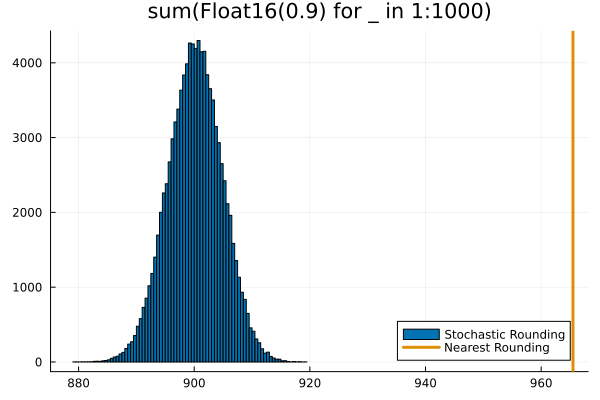

In [5]:
# Set up graph and program
device = Poplar.get_ipu_device()
target = Poplar.DeviceGetTarget(device)
graph = Poplar.Graph(target)
prog = Poplar.ProgramSequence()
# Enable stochastic rounding
Poplar.PoplarSetStochasticRounding(graph, prog, true, "")

# Define the codelet to compute the sum of the input tensor `x` multiple times
# and store the results in the tensor `sums`.
@codelet graph function stochastic_rounding(x::VertexVector{Float16, IPUCompiler.In}, sums::VertexVector{Float16, IPUCompiler.Out})
    for idx in eachindex(sums)
        sums[idx] = sum(x)
    end
end

# Create input and output tensors
sums_sr = Vector{Float16}(undef, 100_000)
x_ipu =  Poplar.GraphAddConstant(graph, x_sr)
sums_ipu = similar(graph, sums_sr)

# Add vertex to the graph
add_vertex(graph, prog, stochastic_rounding, x_ipu, sums_ipu)

# Prepare tensors read
Poplar.GraphCreateHostRead(graph, "sums-read", sums_ipu)

# Run the program
engine = Poplar.Engine(graph, prog)
Poplar.EngineLoadAndRun(engine, device)

# Read the output tensors back to the CPU
Poplar.EngineReadTensor(engine, "sums-read", sums_sr)

# Relase the devices
Poplar.detach_devices()

# Plot the distribution of the stochastic sums
fig = histogram(sums_sr;
                label="Stochastic Rounding",
                title="sum(Float16($(x_sr[1])) for _ in 1:$(length(x_sr)))",
                legend=:bottomright,
                palette=:seaborn_colorblind,
      )
vline!(fig, [sum(x_sr)];
       label="Nearest Rounding",
       linewidth=3,
       )

Some statistics on the distribution `sums_sr` of the sums computed with stochastic rounding:

In [6]:
extrema(sums_sr)

(Float16(879.0), Float16(919.0))

In [7]:
mean(Float64.(sums_sr))

899.90252

In [8]:
std(Float64.(sums_sr))

4.683982498528412

In [9]:
median(sums_sr)

Float16(900.0)

In [10]:
all(isapprox(sum(Float64.(x_sr))), sums_sr)

true